In [2]:
import torchvision.models as models
model = models.vgg16(pretrained=True, progress=True)

In [3]:
from __future__ import division

import random
import os
from os import listdir
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import TensorDataset,Dataset,DataLoader
from tqdm.auto import tqdm

from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms

import argparse
import pydicom
import glob
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from skimage.color import gray2rgb
import functools
import pydicom
import seaborn as sns
import scipy
import PIL

In [62]:
!conda install -c conda-forge gdcm -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr3/graduate/jiamingy/anaconda3

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.0                |   py38h924ce5b_1         3.1 MB  conda-forge
    gdcm-2.8.9                 |   py38h138f8cb_1         3.3 MB  conda-forge
    json-c-0.13.1              |    hbfbb72e_1002          76 KB  conda-forge
    libjpeg-turbo-2.0.5        |       h516909a_0         981 KB  conda-forge
    openjpeg-2.3.1             |       h981e76c_3         475 KB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    -----------------------------------------------------------

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'

train = pd.read_csv(train_csv)
#test_data  = pd.read_csv(data_dir + "/test.csv")
#sample = pd.read_csv(data_dir + "/sample_submission.csv")

cols_ID = ["StudyInstanceUID","SeriesInstanceUID","SOPInstanceUID"]
train["ImagePath"] =train_dir+ train[cols_ID[0]]+"/"+train[cols_ID[1]]+"/"+train[cols_ID[2]]+".dcm"
train["ImageDict"] =train_dir+ train[cols_ID[0]]+"/"+train[cols_ID[1]]

In [7]:
print("{}:{}".format("Number of rows in train data",train.shape[0]))
print("{}:{}".format("Number of columns in train data",train.shape[1]))

Number of rows in train data:1790594
Number of columns in train data:19


In [8]:
train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate,ImagePath,ImageDict
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0,/projectnb/ece601/kaggle-pulmonary-embolism/rs...,/projectnb/ece601/kaggle-pulmonary-embolism/rs...
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0,/projectnb/ece601/kaggle-pulmonary-embolism/rs...,/projectnb/ece601/kaggle-pulmonary-embolism/rs...
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0,/projectnb/ece601/kaggle-pulmonary-embolism/rs...,/projectnb/ece601/kaggle-pulmonary-embolism/rs...
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0,/projectnb/ece601/kaggle-pulmonary-embolism/rs...,/projectnb/ece601/kaggle-pulmonary-embolism/rs...
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0,/projectnb/ece601/kaggle-pulmonary-embolism/rs...,/projectnb/ece601/kaggle-pulmonary-embolism/rs...


In [61]:
dicom.dcmread(train.loc[0,"ImagePath"])

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI DUAL', 'STD', 'SNRG', 'DET_AB']
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: c0f3cb036d06
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice Thickness                     DS: "2.0"
(0018, 0060) KVP                                 DS: "120.0"
(0018, 1120) Gantry/Detector Tilt                DS: "0.0"
(0018, 1130) Table Height                        DS: "139.0"
(0018, 1140) Rotation Direction                  CS: 'CW'
(0018, 1151) X-Ray Tube Current                  IS: "842"
(0018, 1152) Exposure                            IS: "108"
(0018, 1210) Convolution Kernel                  SH: 'B30f'
(0018, 5100) Patient Position                    CS: 'HFS'
(0020, 000d) Study Instance UID                  UI: 6897fa9de148
(0020, 000e)

In [9]:
def dist(column,color):
    sns.distplot(meta_data[column],label=column,color=color)
    plt.legend()

/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/train/af57d9eb2318/966f21d47fd0/f8a8065e355b.dcm


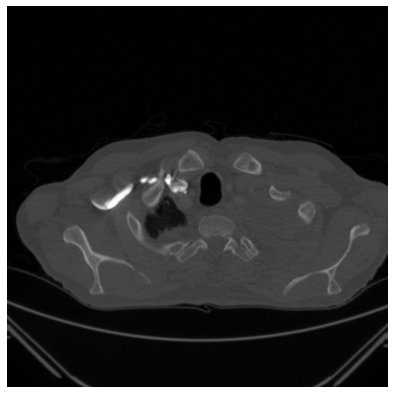

In [56]:
def show_image():
    image_path = train["ImagePath"].sample(n=1).values[0]
    print(image_path)
    image = dicom.dcmread(image_path)
    image = image.pixel_array
    plt.figure(figsize=(7,7))
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.show()
show_image()

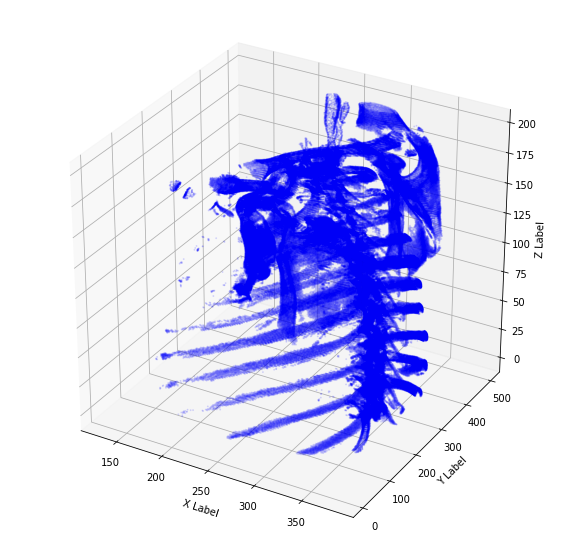

In [64]:
def get_x_y_cordinate(image,n1,n2):
    arr = np.argwhere((image >= n1) & (image <= n2))
    return arr
          
def reconstruct(n1=-1000,n2=2000,s=2,color='b',alpha=0.01,number=1000):
    single_sample = train.sample(n=1)
    image_dict = single_sample["ImageDict"].values[0]
    
    images = [dicom.read_file(image_dict+"/"+filename) for filename in os.listdir(image_dict)]
    images.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111,projection='3d')
    
    for i,image in enumerate(images[:number]):
        img = image.pixel_array
        arr = get_x_y_cordinate(img,n1,n2)
        x = arr[:,0]
        y = arr[:,1]
        z = np.full(shape=len(x),fill_value = i+images[i].SliceThickness)
        ax.scatter(x,y,z,s=s,c=color,alpha=alpha)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()
    
reconstruct(n1=1500,n2=2000,alpha=0.1,s=1)

In [10]:
#!pip install vtk

from sklearn.model_selection import KFold

import vtk
from vtk.util import numpy_support
from tqdm.auto import tqdm

In [11]:
#!pip install opencv

import cv2

In [12]:
#!pip install albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [8]:
class TrainData(Dataset):

    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()
        
        self.df = dataframe
        self.image_ids = dataframe['image_path'].unique()
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, idx: int):
        #Generates one sample of the data
        image_id = self.image_ids[idx]
        image = pydicom.dcmread(f'{self.image_dir}{image_id}.dcm') #Read .dcm file into the loop
        image = image.reshape((512,512,1)).astype('float')

        labels =self.df[['negative_exam_for_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
                     'leftsided_pe', 'chronic_pe', 'rightsided_pe',
                     'acute_and_chronic_pe', 'central_pe', 'indeterminate']].loc[idx].values
        
        if self.transforms:
            image = {"image" : image,} #Create a dictionary of the image values. We can only force the kwargs through transform if they are in dict type
            image = self.transforms(**image)
            
        return image, labels #Return the transformed image, and the associated labels.
    
    def __len__(self) -> int:
        #The loader needs to know how many items we have in our dataset. Therefore we use the __len__ function as an upper-bound.
        return len(self.image_ids)

In [9]:
SEED  = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASSEED']  = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [13]:
target_columns = ['pe_present_on_image', 'negative_exam_for_pe', 'rv_lv_ratio_gte_1', 
                  'rv_lv_ratio_lt_1','leftsided_pe', 'chronic_pe','rightsided_pe', 
                  'acute_and_chronic_pe', 'central_pe', 'indeterminate']

#vtk is used because dicom is giving some error

reader = vtk.vtkDICOMImageReader()
def get_img(path):
    reader.SetFileName(path)
    reader.Update()
    _extent = reader.GetDataExtent()
    ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

    ConstPixelSpacing = reader.GetPixelSpacing()
    imageData = reader.GetOutput()
    pointData = imageData.GetPointData()
    arrayData = pointData.GetArray(0)
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')
    ArrayDicom = cv2.resize(ArrayDicom,(512,512))
    return ArrayDicom


def convert_to_rgb(array):
    array = array.reshape((512, 512, 1))
    return np.stack([array, array, array], axis=2).reshape((3,512, 512))

In [11]:
class RsnaDataset(Dataset):
    
    def __init__(self,df,transforms=None):
        super().__init__()
        self.image_paths = df['ImagePath'].unique()
        self.df = df
        self.transforms = transforms
    
    def __getitem__(self,index):
        
        image_path = self.image_paths[index]
        data = self.df[self.df['ImagePath']==image_path]
        labels = data[target_columns].values.reshape(-1)
        image = get_img(image_path)
        image = convert_to_rgb(image)
        
        if self.transforms:
            image = self.transforms(image=image)['image']
            
        image = torch.tensor(image,dtype=torch.float)        
        labels = torch.tensor(labels,dtype=torch.float)
        
        return image,labels
           
    def __len__(self):
        return self.image_paths.shape[0]  

In [14]:
classes = len(target_columns)
#in_features = model.fc.in_features
#model.fc = nn.Linear(in_features,classes)
model.classifier._modules['6'] = nn.Linear(4096, classes)

In [7]:
config={
       "learning_rate":0.001,
       "train_batch_size":32,
        "valid_batch_size":32,
        "test_batch_size":64,
       "epochs":1,
       "nfolds":3,
       "number_of_samples":10
       }

In [14]:
#https://pytorch.org/hub/pytorch_vision_vgg/
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
#use the dataset that is already preprocessed
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection-265-jpeg/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'

train = pd.read_csv(train_csv)
#test_data  = pd.read_csv(data_dir + "/test.csv")
#sample = pd.read_csv(data_dir + "/sample_submission.csv")

cols_ID = ["StudyInstanceUID","SeriesInstanceUID","SOPInstanceUID"]
train["ImagePath"] =train_dir+ train[cols_ID[0]]+"/"+train[cols_ID[1]]+"/"+train[cols_ID[2]]+".dcm"
train["ImageDict"] =train_dir+ train[cols_ID[0]]+"/"+train[cols_ID[1]]

global_mean = 0.5
global_std = 0.25

transforms=T.Compose([T.Resize(256),
                     T.RandomCrop(224),
                     T.ToTensor(),
                     T.Normalize(mean=[global_mean, global_mean, global_mean], 
                                          std=[global_std, global_std, global_std]),
                    ])


In [15]:
def test():
    model.eval()
    all_prediction = np.zeros((test_data.shape[0],len(target_columns)))
    #study_ids = list()
    #sop_ids = list()
    for i in range(config["nfolds"]):
        #model.load_state_dict(torch.load(f"{model_path}model{i}.bin"))
        predictions = list()
        model.to(device)
        test_ds = RsnaDataset(test_data,transforms=transforms)
        test_dl = DataLoader(test_ds,
                        batch_size=config['test_batch_size'],
                        shuffle=False)
        
        tqdm_loader = tqdm(test_dl)
        
        with torch.no_grad():
            for inputs in tqdm_loader:
                images = inputs[0].to(device, dtype=torch.float)
                outputs = model(images) 
                predictions.extend(outputs.cpu().detach().numpy())
                #if i == 0:
                #    study_ids.extend(inputs["study_id"])
                #    sop_ids.extend(inputs["sop_id"])

        all_prediction += np.array(predictions)/config['nfolds']
        
    return all_prediction

In [18]:
sample = train.sample(n=config["number_of_samples"]).reset_index(drop=True)
test_data = sample
print(sample.shape[0])

10


In [19]:
predictions = test()

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [43]:
print(predictions)
print(predictions.shape)
#len(target_columns)=10

[[   7.8658489   -43.51127052  -31.85557652   21.14995956  -19.70702791
    64.72447777   12.1569767   -68.02050591   -7.45622396   -7.84227014]
 [  13.54289675  -87.0201931   -52.30466652   35.88767624  -61.06025505
   145.79204178   45.00640583 -167.91105652   10.57287383   -8.86587811]
 [  13.62025023  -73.96254158  -63.05927467   31.72016144  -73.97129059
   146.82673645   47.5725317  -157.68264771   -2.4036448   -16.96036005]
 [  16.22675085  -78.11367989  -63.13998985   31.45865536  -62.79244423
   135.15729904   42.29606724 -163.17335129   -4.8429122     0.70419087]
 [  13.60187101  -60.44535828  -50.35612679   29.44317341  -36.8647871
   110.834095     25.55255413 -107.48300171   -4.58700228  -37.30750179]
 [  12.56608629  -97.32389832  -63.31591988   34.21501637  -54.88363266
   141.24243164   41.47705078 -149.77417374  -15.28266191  -27.84675121]
 [  23.94243193  -83.86795235  -64.03418541   49.91352654  -59.8766613
   158.05159378   43.40394688 -159.10827255  -13.02570391  -

In [42]:
test_ds = RsnaDataset(test_data)
test_dl = DataLoader(test_ds,
                batch_size=config['test_batch_size'],
                shuffle=False)
        
tqdm_loader = tqdm(test_dl)
        
with torch.no_grad():
    for inputs in tqdm_loader:
        sample_labels = inputs[1]
        
print(sample_labels)
print(sample_labels.shape)


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]])
torch.Size([10, 10])


In [44]:
def run(plot_losses=True):
  
    def train_loop(train_loader,model,loss_fn,device,optimizer,lr_scheduler=None):
        model.train()
        total_loss = 0
        tqdm_loader = tqdm(train_loader)
        for i, (images, targets) in enumerate(tqdm_loader):
            images,targets = images.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_fn(outputs,targets)
            loss.backward()
                
            total_loss += loss.item()

            optimizer.step()
            if lr_scheduler != None:
                lr_scheduler.step()
                    
        total_loss /= len(train_loader)
        return total_loss
    
    def valid_loop(valid_loader,model,loss_fn,device):
        model.eval()
        total_loss = 0
        predictions = list()
        tqdm_loader = tqdm(valid_loader)

        for i, (images, targets) in enumerate(tqdm_loader):
            images, targets = images.to(device),targets.to(device)
            
            outputs = model(images)                 

            loss = loss_fn(outputs,targets)
            predictions.extend(outputs.detach().cpu().numpy())
            
            total_loss += loss.item()
        total_loss /= len(valid_loader)
            
        return total_loss,np.array(predictions)    
    
    kfold = KFold(n_splits=config["nfolds"])

    fold_train_losses = list()
    fold_valid_losses = list()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(f"{device} is used")
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    for k , (train_idx,valid_idx) in enumerate(kfold.split(train_data)):
        
        x_train,x_valid = train_data.loc[train_idx,:],train_data.loc[valid_idx,:]
        
        model.to(device)

        train_ds = RsnaDataset(x_train)
        train_dl = DataLoader(train_ds,
                             batch_size = config["train_batch_size"],
                             shuffle=True
                             )

        valid_ds = RsnaDataset(x_valid)
        valid_dl = DataLoader(valid_ds,
                             batch_size = config["valid_batch_size"],
                             shuffle=False
                             )
        
        optimizer = optim.Adam(model.parameters(),lr=config["learning_rate"])
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max= 300,eta_min= 0.000001)

        #print(f"Fold {k}")
        best_loss = 999
        train_losses = list()
        valid_losses = list()
        
        for i in range(config['epochs']):
            train_loss = train_loop(train_dl,model,loss_fn,device,optimizer,lr_scheduler)
            valid_loss,predictions = valid_loop(valid_dl,model,loss_fn,device)
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
                          
            #print(f"epoch:{i} Training | loss:{train_loss}  Validation | loss:{valid_loss}  ")
            
            if valid_loss <= best_loss:
                #print(f"{g_}Validation loss Decreased from {best_loss} to {valid_loss}{sr_}")
                best_loss = valid_loss
                torch.save(model.state_dict(),f'model{k}.bin')
                
        fold_train_losses.append(train_losses)
        fold_valid_losses.append(valid_losses)
        
    if plot_losses == True:
        plt.figure(figsize=(20,14))
        for i, (t,v) in enumerate(zip(fold_train_losses,fold_valid_losses)):
            plt.subplot(2,5,i+1)
            plt.title(i)
            plt.plot(t,label="train_loss")
            plt.plot(v,label="valid_loss")
            plt.legend()
        plt.show() 

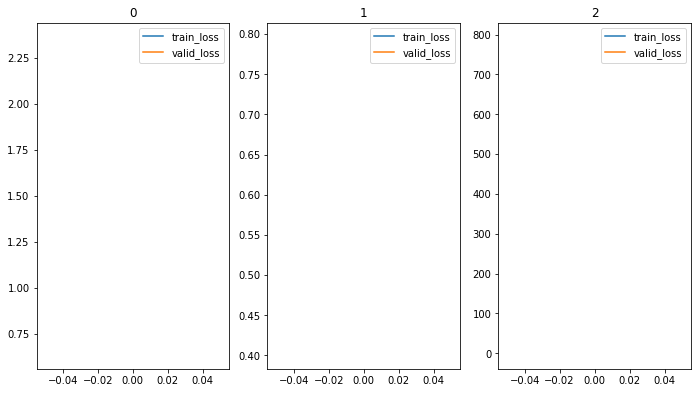

In [47]:
train_data = train.sample(n=config["number_of_samples"]).reset_index(drop=True)
run()

In [49]:
predictions = test()
print(predictions)
print(predictions.shape)


[[-3041.00335693   931.49386597 -1821.50775146  -984.97091675
  -1435.53625488 -2770.69940186 -3049.91381836 -3583.16638184
  -2973.75164795 -4737.421875  ]
 [-5220.52697754  1589.04840088 -3106.86621094 -1721.64056396
  -2486.38037109 -4774.11914062 -5200.37695312 -6136.28723145
  -5081.20495605 -8093.36938477]
 [-5096.46826172  1530.14932251 -3028.68218994 -1662.81756592
  -2390.95074463 -4625.03796387 -5068.71130371 -5985.46142578
  -4949.88244629 -7947.79760742]
 [-5252.98425293  1565.07220459 -3146.28918457 -1729.64794922
  -2471.63983154 -4763.50964355 -5252.35876465 -6179.93188477
  -5114.74401855 -8130.3046875 ]
 [-3387.89794922  1018.93963623 -2000.40527344 -1100.1361084
  -1598.92694092 -3073.81567383 -3366.10620117 -3956.95019531
  -3297.86901855 -5299.40002441]
 [-4890.37902832  1523.24075317 -2918.37890625 -1647.70458984
  -2335.875      -4541.44152832 -4875.9876709  -5751.34973145
  -4750.79772949 -7561.37915039]
 [-5243.10900879  1613.50982666 -3152.80480957 -1719.87707